# TP2: Regresión del valor de valor medio de casas en distritos de California

## Integrantes

- Nicolás Rodrigues da Cruz
- Francisco Cofré
- Gaspar Acevedo Zain
- Juan Chunga
- Rodrigo Nicolás Lauro

### Imports y carga del dataset

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import norm

sns.set()

In [2]:
# Cargamos el dataset - Código provisto por la cátedras
california_housing = fetch_california_housing()

# Obtenemos los atributos y el target:
X = california_housing.data
y = california_housing.target

# Transformamos los datos a estructuras de Pandas:
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos X e y; esto es útil para generar el mapa de calor de correlaciones
df_california = pd.concat([X, y], axis=1)

In [3]:
# Vemos una descripción general del dataset
df_california.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### 1. Obtener la correlación entre los atributos y entre los atributos y el target

1. ¿Qué atributo tiene mayor correlación lineal con el target?
1. ¿Cuáles atributos parecen estar más correlacionados entre sí? Se pueden calcular los coeficientes de correlación o representarlos gráficamente mediante un mapa de calor.

#### 1.1 ¿Qué atributo tiene mayor correlación lineal con el target?

Mediante la función `corr`, obtenemos la correlación entre todas las variables del dataset, incluyendo el target `MedHouseVal`.

La única variable que tiene un valo de correlación alto con el target `MedHouseVal` es:
- `MedInc`, cuyo valor de correlación es $0.688075 \approx 0,69$

Existe una relacion Socioeconomica esperada entre `MedInc` y `AveRooms` cercana al 33%. Es de esperarse que si el ingreso medio crece, tambien tengan mas habitaciones las casas.

El resto de las variables presentan valores bajos (cercanos a ***cero***) de correlación con el target `MedHouseVal`, variando entre $-0.144160 \approx -0.14$ (variable `Latitude`) y $0.151948 \approx 0.15$ (variable `AveRooms`)



#### 1.2 ¿Cuáles atributos parecen estar más correlacionados entre sí?

Mediante la misma función `corr`, obtenemos la correlación entre todas las variables del dataset, incluyendo el target `MedHouseVal`.

La siguiente tabla muestra la correlación de algunas variables del dataframe, ordenandolas por valor absoluto de forma decreciente:

| Variable 01 | Variable 02 | Valor de Correlación |
|---|---|---|
| Longitude | Latitude | $-0.924664 \approx -0.92$|
| AveBedrms | AveRooms | $0.847621 \approx 0.85$|
| AveRooms | MedInc | $0.326895 \approx 0.33$ |
| Population | HouseAge | $-0.296244 \approx -0.30$|

Como se puede observar, las variables `Longitud` y `Latitude` tiene una alta correlación negativa, cuyo valor es $-0.924664 \approx -0.92$. Esto indica que, a medida que los valores de una de esta variable ***crece***, el otro ***decrece***.
Por otro lado, `AveBedrms` y `AveRooms` tienen una alta correlación, con un valor de $0.847621 \approx 0.85$. Esto indica que, a medida que los valores de una de esta variable ***crece***, el otro también ***crece***.

Los otros dos casos listados presentan un valor de correlación relativamente bajo en valor absoluto:
- $0.326895 \approx 0.33$ para `AveRooms` y `MedInc`
- $-0.296244 \approx -0.30$ para `Population` y `HouseAge`

El resto de los casos no los listamos, ya que presentan valores cercanos a cero, es decir, *no hay correlación*.

#### Código y gráficas para resolución de ejercicio 1

In [4]:
# Obtenemos la correlación entre todas las variables del dataframe, incluyendo el target (MedHouseVal)
df_california.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


<Axes: >

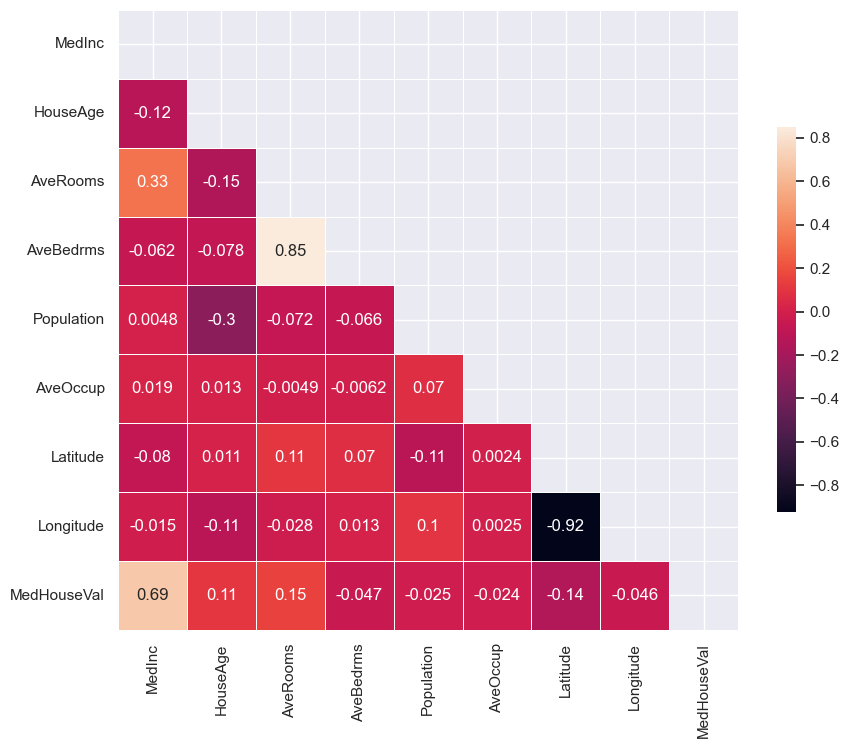

In [5]:
# Fuente: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df_california.corr()

# Se genera una máscara para la parte correspondiente al triángulo superior de la matriz
mask = np.triu(np.ones_like(corr, dtype=bool))

# Tamaño del gráfico de matplotlib
plt.figure(figsize=(10, 10))

sns.heatmap(corr, annot=True, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 2. Graficar los histogramas de los distintos atributos y del target.

1. ¿Qué forma presentan los histogramas?
1. ¿Alguno muestra una distribución similar a una campana que sugiera una distribución gaussiana, sin necesidad de realizar pruebas de hipótesis?

#### 2.1 ¿Qué forma presentan los histogramas?

Hay variables cuyo histograma se asemeja a una distribución normal, pero corridas a izquierda, las cuales son:
- `MedInc`
- `MedHouseVal`

Por otro lado, la variable `HouseAge` tiene cierta semejanza a una distribución normal, pero con rangos en donde la distribución real da por encima del valor de la distribución que espararíamos ver en una distribución normal.

Otras variables, tales como `Longitude` y `Latitude` tienen una semejanza a una variable multimodal, ya que presentan *dos picos*.

El resto de las variables no tienen valores muy dispersos, por lo que parecería que su gráfico no corresponde a una Normal, sino más bien una *columna*. Entre estas columnas se encuentran:
- `AveRooms`
- `AveBedroms`
- `AveOccup`
- `Population`

#### 2.2 ¿Alguno muestra una distribución similar a una campana que sugiera una distribución gaussiana, sin necesidad de realizar pruebas de hipótesis?

Las siguientes variables presentan una distribución similar a una campana, pero corridas a izquierda, conocido como *right-skewed*:
- `MedInc`
- `MedHouseVal`

#### Código y gráficas para resolución de ejercicio 2

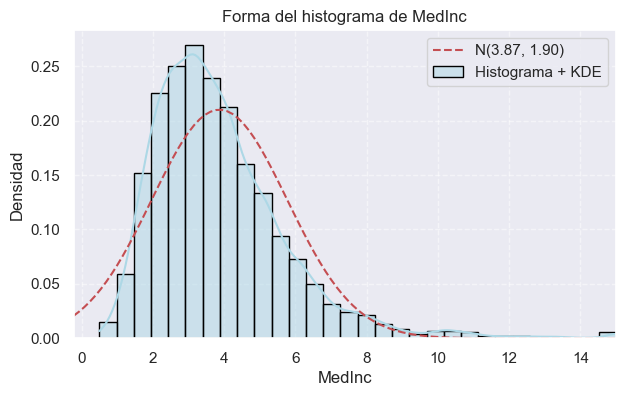

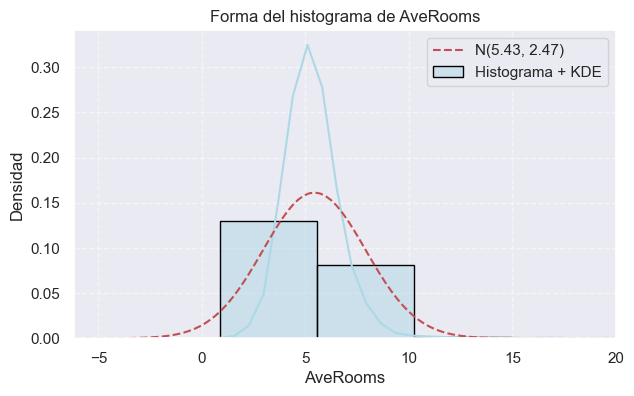

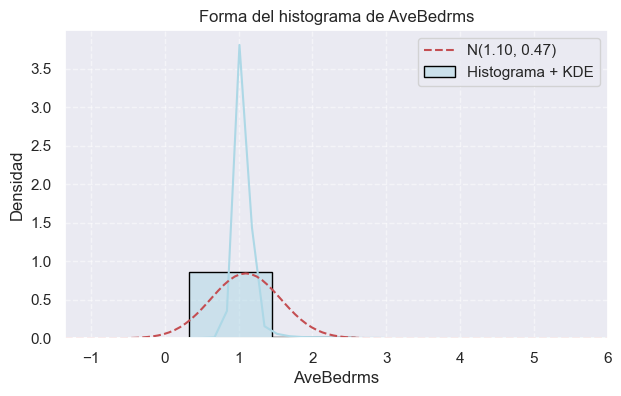

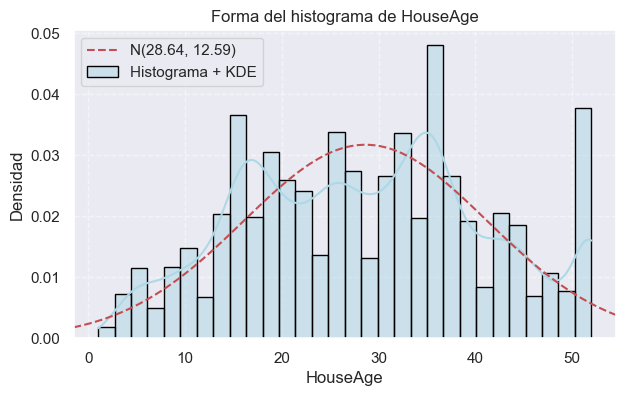

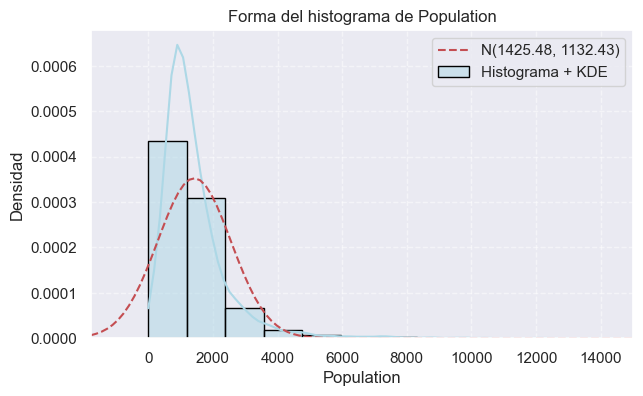

In [36]:
def plot_histogram_shape(df, column, bins=30, xmax=None):
    data = df[column]
    mu, std = norm.fit(data)

    plt.figure(figsize=(7, 4))
    sns.histplot(data, bins=bins, stat="density", kde=True, color="lightblue", edgecolor="black", label="Histograma + KDE")

    # Campana normal ajustada
    xmin, xmax_auto = plt.xlim()
    if xmax:
        xmax_final = xmax
    else:
        xmax_final = xmax_auto

    x = np.linspace(xmin, xmax_final, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', label=f'N({mu:.2f}, {std:.2f})')

    plt.xlim(xmin, xmax_final)
    plt.title(f"Forma del histograma de {column}")
    plt.xlabel(column)
    plt.ylabel("Densidad")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    
plot_histogram_shape(df_california, 'MedInc', xmax=15)
plot_histogram_shape(df_california, 'AveRooms', xmax=20)
plot_histogram_shape(df_california, 'AveBedrms', xmax=6)
plot_histogram_shape(df_california, 'HouseAge')
plot_histogram_shape(df_california, 'Population', xmax=15000)

#### Barras de histograma:
    Muestran la densidad de los datos.

#### Línea suave: KDE (Kernel Density Estimate)
    Es una curva suavizada que estima la distribución real de los datos.

#### Línea punteada roja
    Es una curva normal teórica ajustada a los datos.
    Se basa en la media (mu) y el desvío estándar (std) de los datos reales.

### 3. Calcular una regresión lineal utilizando todos los atributos.
1. Con el conjunto de entrenamiento, calcular la varianza total de los datos y la varianza explicada por el modelo.
1. ¿Está el modelo capturando adecuadamente el comportamiento del target? Fundamente su respuesta.

#### Código y gráficas para la resolución del ejercicio 3

In [7]:
random_state = 100019
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=random_state)

In [8]:
# Creamos el preprocesamiento para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), california_housing['feature_names'])    # Escalamos las variables numéricas
    ]
)

# Creamos el pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Aplicamos la regresión lineal
])

In [9]:
# Entrenamos la regresión lineal
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
feature_names = california_housing['feature_names']
coeficientes = pipeline.named_steps['regressor'].coef_

print("Coeficientes del modelo lineal:\n")
for nombre, valor in zip(feature_names, coeficientes):
    print(f"{nombre:12s}: {valor:.2f}")
 
intercepto = pipeline.named_steps['regressor'].intercept_
r2 = pipeline.score(X_train, y_train)

print(f"\nEl valor de la intersección de la recta es: {intercepto:.2f}")

Coeficientes del modelo lineal:

MedInc      : 0.83
HouseAge    : 0.12
AveRooms    : -0.26
AveBedrms   : 0.30
Population  : -0.01
AveOccup    : -0.04
Latitude    : -0.90
Longitude   : -0.87

El valor de la intersección de la recta es: 2.07


In [11]:
# Calculamos el desvío estándar residual
y_model = pipeline.predict(X_train)
num_attributes = len(pipeline.named_steps['preprocessor'].get_feature_names_out())

var_model = np.sum((y_train - y_model)**2)/(y_train.size - num_attributes - 1)
std_dev_model = np.sqrt(var_model)

print(f"Desvío estándar del modelo {round(std_dev_model, 3)}")
print(f"Varianza del modelo {round(var_model, 3)}")

Desvío estándar del modelo 0.727
Varianza del modelo 0.528


In [37]:
# --- VARIANZA TOTAL Y EXPLICADA ---------------------------------
# total (poblacional) – ddof=0 divide por n
var_total = np.var(y_train, ddof=0)

# varianza "explicada" por el modelo (dispersión de las predicciones)
var_explic = np.var(y_model, ddof=0)

explained_ratio = var_explic / var_total

print(f"Varianza total      : {var_total:.3f}")
print(f"Varianza explicada  : {var_explic:.3f}")
print(f"% varianza explicada: {explained_ratio:.1%}")
print(f"R² reportado        : {r2:.4f}")
print(f"Diferencia (| % - R² |): {abs(explained_ratio - r2):.4e}")


Varianza total      : 1.335
Varianza explicada  : 0.808
% varianza explicada: 60.5%
R² reportado        : 0.6093
Diferencia (| % - R² |): 4.6057e-03


El modelo lineal logra explicar alrededor del 60 % de las diferencias de precio entre los barrios: los bloques con mayores ingresos y los que están cerca de la costa tienden a mostrar valores más altos, y eso se refleja bien en las predicciones.

Aun así, queda casi un 40 % que el modelo no alcanza a justificar. Lo notamos sobre todo en las casas más caras, donde el error se agranda, allí el modelo suele subestimar cuánto pueden variar los precios.

Se podria decir que el ajuste es “bueno, pero no perfecto”. Para mejorar lo que falta se podría añadir más variables (por ejemplo, distancia a servicios o calidad de las escuelas) o probar modelos que capten relaciones no lineales.

### 4. Calcular las métricas de MSE, MAE y R² sobre el conjunto de evaluación.

#### Código para la resolución del ejercicio 4

In [13]:
# Primero, calculamos la predicción de nuestro modelo en el dataset de test
y_pred = pipeline.predict(X_test)

In [14]:
# Una vez hecha la predicción en test, seguimos con el cálculo de métricas entre los valores "reales" en test, y su predicción
r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nMétricas del modelo Lineal")
print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))

print(f"Error absoluto porcentual medio: {mape*100:.2f}%")



Métricas del modelo Lineal
R-cuadrado en test: 0.609
Error absoluto medio: 0.53
Error cuadrático medio: 0.517
Raíz de error cuadrático medio: 0.719
Error absoluto porcentual medio: 32.02%


### 5. Crear una regresión de Ridge

1. Usar validación cruzada de 5 folds y tomar como métrica el MSE.
1. Buscar el mejor valor de α en el rango [0, 12.5].
1. Graficar el MSE en función de α.

#### Código y gráficos para la resolución del punto 5

In [15]:
preprocessor_kfolds = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), california_housing['feature_names'])    # Escalamos las variables numéricas
    ]
)

X_train_processed = preprocessor_kfolds.fit_transform(X_train)

X_test_processed = preprocessor_kfolds.fit_transform(X_test)

In [16]:
# Definimos el alfa mínimo, alfa máximo, y la cantidad de subdivisiones
alpha_min = 0
alpha_max = 12.5
alpha_subdivisions = 100

alpha_array = np.linspace(alpha_min, alpha_max, alpha_subdivisions)

# Definimos la cantidad de folds
number_of_folds = 5

cv_mse_ridge_errors = []
cv_mae_ridge_errors = []

In [17]:
for alpha in alpha_array:

    ridge = Ridge(alpha=alpha)
    if alpha == 0:
        ridge = LinearRegression()

    # Scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
    cv_mse = cross_val_score(ridge, X_train_processed, y=y_train, scoring="neg_mean_squared_error", cv=number_of_folds, n_jobs=-1)
    cv_mae = cross_val_score(ridge, X_train_processed, y=y_train, scoring="neg_mean_absolute_error", cv=number_of_folds, n_jobs=-1)

    # Calcular el MAE y MSE para cada Alfa (multiplicamos por -1 porque el cross_val_score devuelve números negativos)
    cv_mse_mean = cv_mse.mean() * -1
    cv_mae_mean = cv_mae.mean() * -1

    cv_mse_ridge_errors.append(cv_mse_mean)
    cv_mae_ridge_errors.append(cv_mae_mean)

# Mostramos cual es el mejor valor de alpha para Ridge
best_alpha_mse_ridge = alpha_array[np.argmin(cv_mse_ridge_errors)]
best_alpha_mae_ridge = alpha_array[np.argmin(cv_mae_ridge_errors)]

print(f"El mejor valor de alpha para Ridge (MSE) es: {best_alpha_mse_ridge}")
print(f"El mejor valor de alpha para Ridge (MAE) es: {best_alpha_mae_ridge}")


# Entrenar modelo final con mejor alpha (para MSE)
ridge_final = Ridge(alpha=best_alpha_mse_ridge)
ridge_final.fit(X_train_processed, y_train)

# Predicción sobre el set de evaluación
y_pred_ridge = ridge_final.predict(X_test_processed)

# Cálculo de métricas finales
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

# Mostrar resultados
print("\nMétricas del modelo Ridge con mejor alpha:")
print("R-cuadrado en test:", round(r2_ridge, 3))
print("Error absoluto medio:", round(mae_ridge, 3))
print("Error cuadrático medio:", round(mse_ridge, 3))
print("Raíz de error cuadrático medio:", round(rmse_ridge, 3))

print(f"Error absoluto porcentual medio: {mape_ridge * 100:.2f}%")


 

El mejor valor de alpha para Ridge (MSE) es: 12.5
El mejor valor de alpha para Ridge (MAE) es: 12.5

Métricas del modelo Ridge con mejor alpha:
R-cuadrado en test: 0.617
Error absoluto medio: 0.525
Error cuadrático medio: 0.506
Raíz de error cuadrático medio: 0.712
Error absoluto porcentual medio: 32.01%


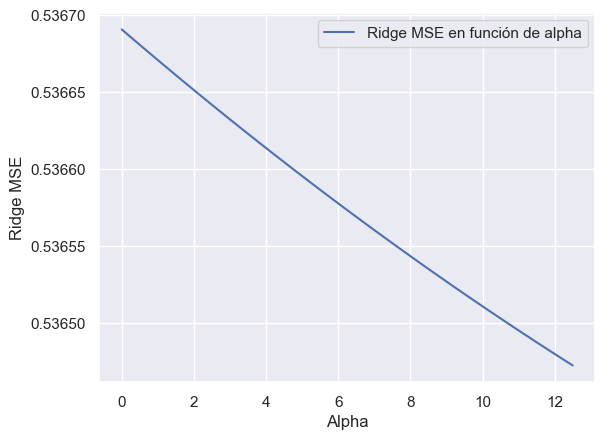

In [18]:
plt.plot(alpha_array, cv_mse_ridge_errors, label='Ridge MSE en función de alpha')
plt.xlabel("Alpha")
plt.ylabel("Ridge MSE")
plt.legend()
plt.show()

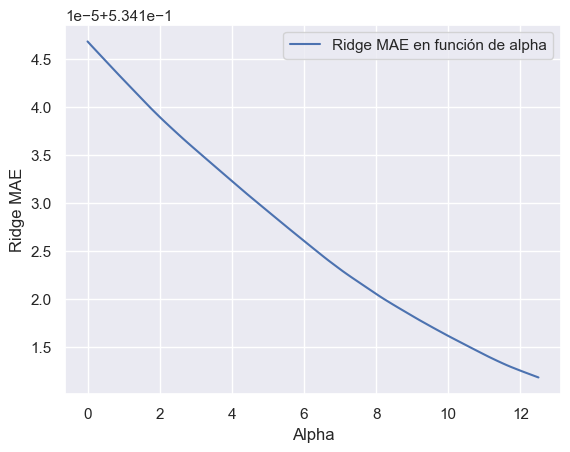

In [19]:
plt.plot(alpha_array, cv_mae_ridge_errors, label='Ridge MAE en función de alpha')
plt.xlabel("Alpha")
plt.ylabel("Ridge MAE")
plt.legend()
plt.show()

### Utilizamos un Alfa mayor , ya que la curva no toca el piso

El mejor valor de alpha para Ridge (MSE) es: 54.94949494949495
El mejor valor de alpha para Ridge (MAE) es: 17.77777777777778

Métricas del modelo Ridge con mejor alpha:
R-cuadrado en test: 0.617
Error absoluto medio: 0.525
Error cuadrático medio: 0.507
Raíz de error cuadrático medio: 0.712
Error absoluto porcentual medio: 31.98%


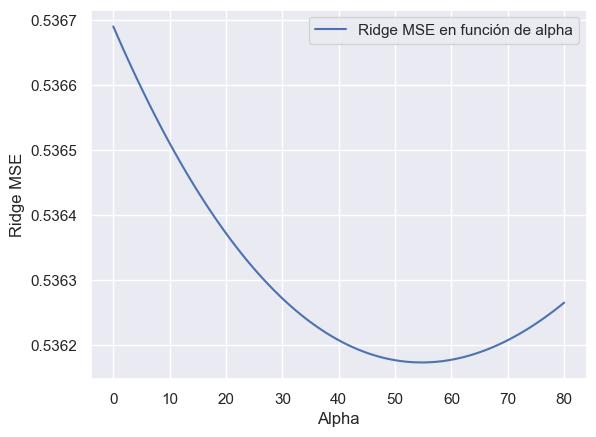

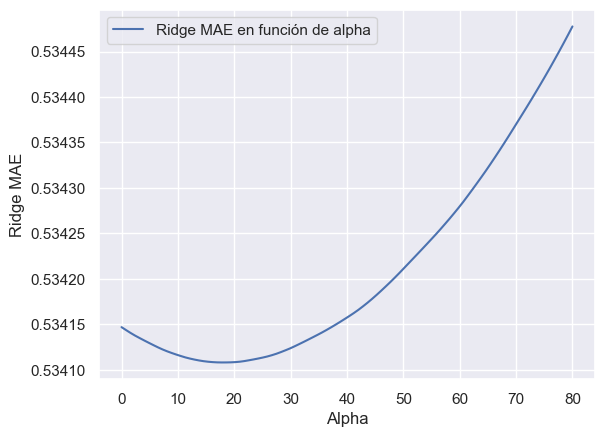

In [20]:
alpha_max = 80

alpha_subdivisions = 100

alpha_array = np.linspace(alpha_min, alpha_max, alpha_subdivisions)

# Definimos la cantidad de folds
number_of_folds = 5

cv_mse_ridge_errors = []
cv_mae_ridge_errors = []

for alpha in alpha_array:

    ridge = Ridge(alpha=alpha)
    if alpha == 0:
        ridge = LinearRegression()

    # Scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#string-name-scorers
    cv_mse = cross_val_score(ridge, X_train_processed, y=y_train, scoring="neg_mean_squared_error", cv=number_of_folds, n_jobs=-1)
    cv_mae = cross_val_score(ridge, X_train_processed, y=y_train, scoring="neg_mean_absolute_error", cv=number_of_folds, n_jobs=-1)

    # Calcular el MAE y MSE para cada Alfa (multiplicamos por -1 porque el cross_val_score devuelve números negativos)
    cv_mse_mean = cv_mse.mean() * -1
    cv_mae_mean = cv_mae.mean() * -1

    cv_mse_ridge_errors.append(cv_mse_mean)
    cv_mae_ridge_errors.append(cv_mae_mean)

# Mostramos cual es el mejor valor de alpha para Ridge
best_alpha_mse_ridge = alpha_array[np.argmin(cv_mse_ridge_errors)]
best_alpha_mae_ridge = alpha_array[np.argmin(cv_mae_ridge_errors)]

print(f"El mejor valor de alpha para Ridge (MSE) es: {best_alpha_mse_ridge}")
print(f"El mejor valor de alpha para Ridge (MAE) es: {best_alpha_mae_ridge}")


# Entrenar modelo final con mejor alpha (para MSE)
ridge_final = Ridge(alpha=best_alpha_mse_ridge)
ridge_final.fit(X_train_processed, y_train)

# Predicción sobre el set de evaluación
y_pred_ridge = ridge_final.predict(X_test_processed)

# Cálculo de métricas finales
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

# Mostrar resultados
print("\nMétricas del modelo Ridge con mejor alpha:")
print("R-cuadrado en test:", round(r2_ridge, 3))
print("Error absoluto medio:", round(mae_ridge, 3))
print("Error cuadrático medio:", round(mse_ridge, 3))
print("Raíz de error cuadrático medio:", round(rmse_ridge, 3))

print(f"Error absoluto porcentual medio: {mape_ridge * 100:.2f}%")


plt.plot(alpha_array, cv_mse_ridge_errors, label='Ridge MSE en función de alpha')
plt.xlabel("Alpha")
plt.ylabel("Ridge MSE")
plt.legend()
plt.show()


plt.plot(alpha_array, cv_mae_ridge_errors, label='Ridge MAE en función de alpha')
plt.xlabel("Alpha")
plt.ylabel("Ridge MAE")
plt.legend()
plt.show()

#### ALTERNATIVA

In [21]:
scaler__2 = StandardScaler()
X_train_scaled__2 = scaler__2.fit_transform(X_train)
X_test_scaled__2 = scaler__2.transform(X_test)

X_train_scaled__2 = pd.DataFrame(X_train_scaled__2, columns=california_housing['feature_names'])
X_test_scaled__2 = pd.DataFrame(X_test_scaled__2, columns=california_housing['feature_names'])

In [22]:
alpha_min__2 = 0
alpha_max__2 = 12.5
alpha_subdivisions__2 = 100

alpha_array__2 = np.linspace(alpha_min__2, alpha_max__2, alpha_subdivisions__2)

In [23]:
# https://scikit--learn-org.translate.goog/stable/modules/generated/sklearn.linear_model.RidgeCV.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc#ridgecv
from sklearn.linear_model import RidgeCV

mse_ridge_v2 = "neg_mean_squared_error"
rmse_ridge_v2 = "neg_root_mean_squared_error"
other_ridge_v2 = "neg_max_error"

model_ridge_cv_v2 = RidgeCV(alphas=alpha_array__2, cv=5, scoring=mse_ridge_v2)

In [24]:
results_ridge_v2 = model_ridge_cv_v2.fit(X_train_scaled__2, y_train)


In [25]:
print ("The score with the best alpha is:",
       f"{results_ridge_v2.best_score_:.3f}")
print ("The error with the best alpha is:",
       f"{-results_ridge_v2.best_score_:.3f}")
print ("The best value for alpha:", results_ridge_v2.alpha_)

The score with the best alpha is: -0.536
The error with the best alpha is: 0.536
The best value for alpha: 12.5


### 5. Respuesta: 
    El modelo de Ridge Regression obtiene resultados levemente mejores en todas las métricas evaluadas. Tanto el MSE como el MAE son inferiores respecto a la regresión lineal:
    MAE bajó de 0.530 a 0.525
    MSE bajó de 0.517 a 0.506
La diferencia es pequeña pero consistente en todas las métricas. No es una mejora drástica, pero sí evidencia que la regularización de Ridge aporta una pequeña ventaja en la generalización del modelo.

### 6. **Comparar los resultados** obtenidos entre la regresión lineal y la mejor regresión de Ridge, evaluando el conjunto de prueba.

1. ¿Cuál de los dos modelos obtiene mejores resultados en términos de MSE y MAE? ¿Poseen suficiente diferencia como para indicar si uno es mejor que el otro?
2. ¿Qué tipo de error podría haberse reducido?

#### Código para resolución punto 6

In [26]:
# Primero, redefinimos los preprocesadores y pipelines para Ridge
preprocessor_ridge = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), california_housing['feature_names'])
    ]
)

pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor_ridge),
    ('regressor', Ridge(alpha=best_alpha_mse_ridge))
])

# hacemos el entrenamiento
pipeline_ridge.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
y_pred_ridge = pipeline_ridge.predict(X_test)

r2_ridge_v2 = r2_score(y_test, y_pred_ridge)
mae_ridge_v2 = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge_v2 = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge_v2 = root_mean_squared_error(y_test, y_pred_ridge)
mape_ridge_v2 = mean_absolute_percentage_error(y_test, y_pred_ridge)

print("Regresión de Ridge")
print("------------------")
print("R-cuadrado en test:", round(r2_ridge_v2, 3))
print("Error absoluto medio:", round(mae_ridge_v2, 3))
print("Error cuadrático medio:", round(mse_ridge_v2, 3))
print("Raíz de error cuadrático medio:", round(rmse_ridge_v2, 3))
print(f"Error absoluto porcentual medio: {mape_ridge_v2*100:.2f}%")

Regresión de Ridge
------------------
R-cuadrado en test: 0.609
Error absoluto medio: 0.53
Error cuadrático medio: 0.517
Raíz de error cuadrático medio: 0.719
Error absoluto porcentual medio: 31.98%


In [28]:


# Ya tenés métricas del modelo Ridge: r2_ridge, mae_ridge, etc.

# Mostrar comparación en tabla
import pandas as pd

comparacion = pd.DataFrame({
    "Métrica": ["R²", "MAE", "MSE", "RMSE", "MAPE (%)"],
    "Regresión Lineal": [
        round(r2, 3),
        round(mae, 3),
        round(mse, 3),
        round(rmse, 3),
        f"{mape * 100:.2f}%"
    ],
    "Ridge Regression": [
        round(r2_ridge, 3),
        round(mae_ridge, 3),
        round(mse_ridge, 3),
        round(rmse_ridge, 3),
        f"{mape_ridge * 100:.2f}%"
    ]
})

display(comparacion)


,Métrica,Regresión Lineal,Ridge Regression
0,R²,0.609,0.617
1,MAE,0.53,0.525
2,MSE,0.517,0.507
3,RMSE,0.719,0.712
4,MAPE (%),32.02%,31.98%


### Seleccion de modelo segun AIC
  Buscamos la mejor combinacion de features.
  Para ello, no tenemos en cuenta `AveBedrms` ya que es similar a `AveRooms`

In [29]:
def aic_criterion(y: np.ndarray, y_pred: np.ndarray, num_attributes: int) -> float:
     
    # Agregamos uno porque hay que incorporar a la ordenada al origen
    d = num_attributes + 1
    N = y.shape[0]

    # Calculamos los residuos al cuadrado
    residuals = y - y_pred
    Se = np.sum(residuals**2)

    # Calculamos la estimación del logaritmo de maxima similitud de la regresión lineal
    #Rod: representa una estimación de la parte constante en la log-verosimilitud de un modelo lineal bajo la suposición de errores normales.
    log_lik = np.log(2*np.pi) + np.log(Se/N) + 1
    log_lik *= -N/2

    #Calculamos ambos criterios
    aic = 2*d - 2*log_lik 
   
    return aic

In [30]:
from sklearn.linear_model import LinearRegression

def train_reg_model(X: pd.DataFrame, y: np.ndarray, columns: list) -> float:
    """
    Entrena un modelo de regresión lineal y devuelve el AIC.
    """
    X_clear = X.loc[:, columns].copy()

    model = LinearRegression()
    model.fit(X_clear, y)
    y_pred = model.predict(X_clear)

    return aic_criterion(y, y_pred, X_clear.shape[1])

In [31]:
# Suponiendo que X_train_scaled es un DataFrame con columnas estandarizadas
columns_list = [
   
    ['MedInc', 'AveRooms', 'AveBedrms'],
    ['MedInc', 'HouseAge'],
    ['MedInc',  'AveRooms'],
    ['MedInc', 'HouseAge', 'AveRooms', 'Population'],
    ['MedInc', 'Latitude', 'Longitude'],   
    ['MedInc',  'AveRooms','Population'],
    ['MedInc', 'Latitude', 'Longitude', 'AveRooms'],
    ['MedInc', 'Latitude', 'Longitude', 'AveRooms','Population'],
    ['MedInc', 'Latitude', 'Longitude', 'AveRooms','Population','HouseAge'],
    ['MedInc', 'Latitude', 'Longitude', 'AveRooms','Population','HouseAge', 'AveBedrms']
]

for cols in columns_list:
    aic = train_reg_model(X_train, y_train, cols)
    print(f"AIC usando {cols}: {aic:.2f}")

AIC usando ['MedInc', 'AveRooms', 'AveBedrms']: 34981.22
AIC usando ['MedInc', 'HouseAge']: 34908.06
AIC usando ['MedInc', 'AveRooms']: 35807.72
AIC usando ['MedInc', 'HouseAge', 'AveRooms', 'Population']: 34819.62
AIC usando ['MedInc', 'Latitude', 'Longitude']: 32565.44
AIC usando ['MedInc', 'AveRooms', 'Population']: 35776.03
AIC usando ['MedInc', 'Latitude', 'Longitude', 'AveRooms']: 32536.84
AIC usando ['MedInc', 'Latitude', 'Longitude', 'AveRooms', 'Population']: 32484.13
AIC usando ['MedInc', 'Latitude', 'Longitude', 'AveRooms', 'Population', 'HouseAge']: 32161.65
AIC usando ['MedInc', 'Latitude', 'Longitude', 'AveRooms', 'Population', 'HouseAge', 'AveBedrms']: 31831.53


### AIC Resultado
   Al comparar distintas combinaciones de variables utilizando el Criterio de Información de Akaike (AIC), se observó que el modelo con 7 features (MedInc, Latitude, Longitude, AveRooms, Population, HouseAge, AveBedrms) obtuvo el AIC más bajo (31831.53). Esto indica que logra el mejor equilibrio entre calidad de ajuste y complejidad del modelo, siendo la opción óptima para este conjunto de datos

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Lista de mejores features
selected_features = ['MedInc', 'Latitude', 'Longitude', 'AveRooms', 'Population', 'HouseAge', 'AveBedrms']


# Redefinir preprocesamiento solo con esas columnas
preprocessor_subset = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ]
)

# Pipeline con regresión lineal
pipeline_subset = Pipeline(steps=[
    ('preprocessor', preprocessor_subset),
    ('regressor', LinearRegression())
])

# Entrenar con X_train y predecir sobre X_test
pipeline_subset.fit(X_train[selected_features], y_train)
y_pred_subset = pipeline_subset.predict(X_test[selected_features])

# Calcular métricas
r2_subset = r2_score(y_test, y_pred_subset)
mae_subset = mean_absolute_error(y_test, y_pred_subset)
mse_subset = mean_squared_error(y_test, y_pred_subset)
rmse_subset = root_mean_squared_error(y_test, y_pred_subset)
mape_subset = mean_absolute_percentage_error(y_test, y_pred_subset)

# Mostrar resultados
print("\nMétricas del modelo Lineal (solo con features seleccionadas)")
print("R-cuadrado en test:", round(r2_subset, 3))
print("Error absoluto medio:", round(mae_subset, 3))
print("Error cuadrático medio:", round(mse_subset, 3))
print("Raíz de error cuadrático medio:", round(rmse_subset, 3))
print(f"Error absoluto porcentual medio: {mape_subset * 100:.2f}%")


Métricas del modelo Lineal (solo con features seleccionadas)
R-cuadrado en test: 0.608
Error absoluto medio: 0.531
Error cuadrático medio: 0.518
Raíz de error cuadrático medio: 0.72
Error absoluto porcentual medio: 32.08%


In [34]:

comparacion = pd.DataFrame({
    "Métrica": ["R²", "MAE", "MSE", "RMSE", "MAPE (%)"],
    "Regresión Lineal": [
        round(r2, 3),
        round(mae, 3),
        round(mse, 3),
        round(rmse, 3),
        f"{mape * 100:.2f}%"
    ],
    "Ridge Regression": [
        round(r2_ridge, 3),
        round(mae_ridge, 3),
        round(mse_ridge, 3),
        round(rmse_ridge, 3),
        f"{mape_ridge * 100:.2f}%"
    ],
    "Lineal (Subset de Features)": [
        round(r2_subset, 3),
        round(mae_subset, 3),
        round(mse_subset, 3),
        round(rmse_subset, 3),
        f"{mape_subset * 100:.2f}%"
    ]
})

display(comparacion)

,Métrica,Regresión Lineal,Ridge Regression,Lineal (Subset de Features)
0,R²,0.609,0.617,0.608
1,MAE,0.53,0.525,0.531
2,MSE,0.517,0.507,0.518
3,RMSE,0.719,0.712,0.72
4,MAPE (%),32.02%,31.98%,32.08%


### Conclusion luego de AIC 
 Aunque la regresión lineal con subset de features no mejora las métricas tradicionales frente al modelo completo o Ridge, el valor de AIC es significativamente menor. Esto sugiere que, desde una perspectiva de balance entre ajuste y complejidad, el modelo reducido es más eficiente, aunque no necesariamente más preciso.